If you haven't installed `coco-visualize` yet, run the cell below. 
It runs `pip install -U coco-visualize` from inside the notebook. 
You could also run the above command in a terminal.

In [ ]:
import sys

print(f"Installing `coco-visualize` for {sys.executable}.")
!"{sys.executable}" -m pip install -U coco-visualize

Now we are ready to load all the required libraries.

In [1]:
import itertools
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from pathlib import Path
from cocoviz import ProblemDescription, Result, ResultSet, Indicator, rtpplot

DATA_DIR = Path("data/")

# Load demo results

Here we are going to look at some data where we ran `MOEAD`, `NSGA-II`, and `GDE3` three times on `ZDT[1..4,6]` with 10 or 30 dimensions.
The data is hosted in an S3 bucket and needs to be downloaded the first time you run the notebook. 
Afterwards it is stored locally in Parquet files.

Let us define all results we expect to find:

In [2]:
ALGORITHMS = ["MOEAD", "NSGA-II", "GDE3"]
FUNCTIONS = ["ZDT1", "ZDT2", "ZDT3", "ZDT4", "ZDT6"]
VARS = [10, 30]
RUN = [1, 2, 3]
ALL_RESULTS = list(itertools.product(ALGORITHMS, FUNCTIONS, VARS, RUN))

Now we can iterate over the expected results, load them from the local Parquet file if present or download them otherwise.
This shows you both how to load data from a CSV file as well as quickly reloading data from binary files.

In [3]:
import pyarrow
results = ResultSet()

for alg, fn, var, run in tqdm(ALL_RESULTS):
    LOCAL = Path(f"result-{alg}_{fn}_{var}_{run}.parquet")
    if not LOCAL.exists():  # Need to fetch results over the network
        URL = f"https://cocoviz-demo-data.s3.us-west-000.backblazeb2.com/{alg}_{fn}_vars={var}_run={run}.csv"
        data = pd.read_csv(URL)
        # Add artifical performance indicator that must be minimized
        data["neg_hv"] = -data["Hypervolume"]

        problem = ProblemDescription(fn, 1, var, 2)
        result = Result(alg, problem, data, "Evaluations")
        result.to_parquet(LOCAL)

    results.append(Result.from_parquet(LOCAL))

  0%|          | 0/90 [00:00<?, ?it/s]

# Create a runtime profile plot each problem in the result set

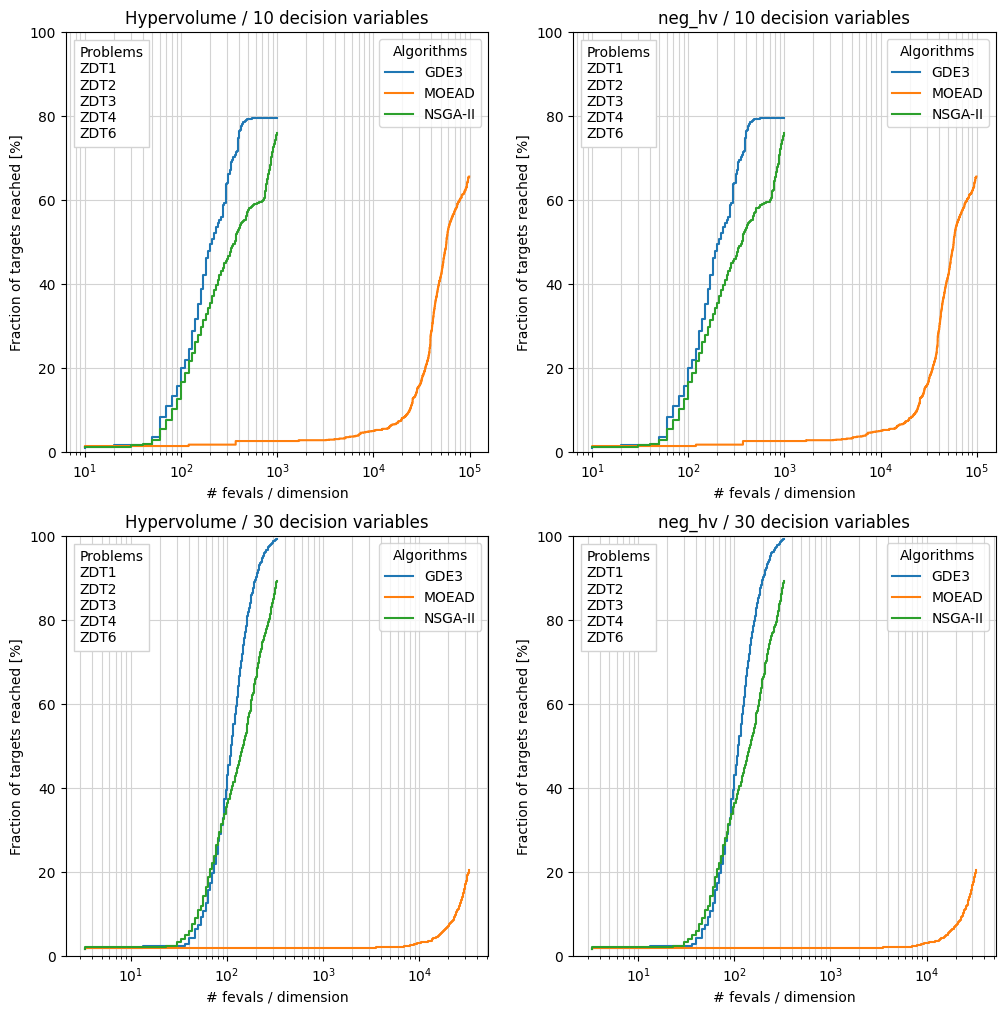

In [4]:
number_of_targets = 101

INDICATOR = [Indicator("Hypervolume", larger_is_better=True), Indicator("neg_hv", larger_is_better=False)]

nvar = len(results.number_of_variables)
fig, axes = plt.subplots(nvar, 2, figsize=(12, 12))
for axrow, (d, result_subset) in zip(axes, results.by_number_of_variables()):
    for ax, ind in zip(axrow, INDICATOR):
        rtpplot(result_subset, ind, number_of_targets=number_of_targets, ax=ax)
        ax.set_title(f"{ind.name} / {d} decision variables")